In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from datetime import datetime
from statsforecast import StatsForecast
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from tabulate import tabulate

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

#Import the models
from statsforecast.models import HistoricAverage, Naive, RandomWalkWithDrift, SeasonalNaive,  HoltWinters
from statsforecast.models import AutoARIMA, DynamicOptimizedTheta

#Import evaluation metrics from scikit-learn
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error


C:\Users\roych\anaconda3\Lib\site-packages\statsforecast\core.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [3]:
warnings.filterwarnings("ignore")

### Reading the Data:

In [4]:
df = pd.read_csv('All_India_Index_jan2019.csv')

In [5]:
df.head()

Sector  Year     Month  Cereals and products  Meat and fish    Egg  \
0  Urban  2013   January                 110.5          109.1  113.0   
1  Urban  2013  February                 112.9          112.9  116.9   
2  Urban  2013     March                 113.9          111.4  113.2   
3  Urban  2013     April                 114.6          113.4  106.0   
4  Urban  2013       May                 115.4          114.2  102.7   

   Milk and products  Oils and fats  Fruits  Vegetables  ...  Housing  \
0              103.6          103.4   102.3       102.9  ...    100.3   
1              104.0          103.5   103.1       104.9  ...    100.4   
2              104.3          102.7   104.9       103.8  ...    100.4   
3              104.7          102.1   109.5       109.7  ...    100.5   
4              105.5          101.5   110.6       123.7  ...    100.5   

   Fuel and light  Household goods and services  Health  \
0           105.4                         104.8   104.1   
1           105.7                         105.2   104.7   
2           106.0                         105.7   105.2   
3           106.4                         106.5   105.7   
4           107.2                         107.1   106.2   

   Transport and communication  Recreation and amusement  Education  \
0                        103.2                     102.9      103.5   
1                        104.4                     103.3      103.7   
2                        105.5                     103.5      103.8   
3                        105.0                     104.0      105.2   
4                        103.9                     104.6      105.7   

   Personal care and effects  Miscellaneous  General index  
0                      104.3          103.7          104.0  
1                      104.3          104.3          104.7  
2                      104.2          104.9          105.0  
3                      103.2          105.1          105.7  
4                      102.6          104.9          106.6  

[5 rows x 30 columns]

In [6]:
df.tail()

Sector  Year      Month  Cereals and products  Meat and fish    Egg  \
68  Urban  2018  September                 137.0          143.1  132.8   
69  Urban  2018    October                 137.6          144.9  133.5   
70  Urban  2018   November                 138.1          146.3  137.8   
71  Urban  2018   December                 138.5          147.8  141.1   
72  Urban  2019    January                 138.3          149.4  143.5   

    Milk and products  Oils and fats  Fruits  Vegetables  ...  Housing  \
68              141.5          117.8   140.0       151.3  ...    145.3   
69              141.5          118.0   139.5       153.0  ...    146.3   
70              141.6          118.1   141.5       145.2  ...    146.9   
71              141.6          118.1   138.5       132.4  ...    146.5   
72              141.7          118.1   135.2       130.5  ...    147.7   

    Fuel and light  Household goods and services  Health  \
68           131.2                         134.9   135.7   
69           133.4                         135.1   136.2   
70           136.7                         135.8   136.8   
71           132.4                         136.2   137.3   
72           128.6                         136.3   137.8   

    Transport and communication  Recreation and amusement  Education  \
68                        122.5                     130.2      145.2   
69                        123.3                     130.7      145.5   
70                        121.2                     131.3      146.1   
71                        118.8                     131.7      146.5   
72                        118.6                     131.9      146.6   

    Personal care and effects  Miscellaneous  General index  
68                      129.3          131.9          138.1  
69                      130.4          132.5          138.9  
70                      130.5          132.2          139.0  
71                      130.8          131.7          138.0  
72                      131.7          131.8          138.0  

[5 rows x 30 columns]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 30 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Sector                               73 non-null     object 
 1   Year                                 73 non-null     int64  
 2   Month                                73 non-null     object 
 3   Cereals and products                 73 non-null     float64
 4   Meat and fish                        73 non-null     float64
 5   Egg                                  73 non-null     float64
 6   Milk and products                    73 non-null     float64
 7   Oils and fats                        73 non-null     float64
 8   Fruits                               73 non-null     float64
 9   Vegetables                           73 non-null     float64
 10  Pulses and products                  73 non-null     float64
 11  Sugar and Confectionery           

### Format the Data:

In [8]:
df['Month'] = df['Month'].apply(lambda x: datetime.strptime(x, '%B').month)
df['YearMonth'] = df['Year'].astype(str) + '-' + df['Month'].apply(lambda x: f"{x:02d}")
df['Date'] = pd.to_datetime(df['YearMonth'], format='%Y-%m')
df.drop(columns=['Year','Month'], inplace=True)
#df.set_index('Date', inplace=True)

In [9]:
df.head()

Sector  Cereals and products  Meat and fish    Egg  Milk and products  \
0  Urban                 110.5          109.1  113.0              103.6   
1  Urban                 112.9          112.9  116.9              104.0   
2  Urban                 113.9          111.4  113.2              104.3   
3  Urban                 114.6          113.4  106.0              104.7   
4  Urban                 115.4          114.2  102.7              105.5   

   Oils and fats  Fruits  Vegetables  Pulses and products  \
0          103.4   102.3       102.9                105.8   
1          103.5   103.1       104.9                104.1   
2          102.7   104.9       103.8                103.5   
3          102.1   109.5       109.7                104.6   
4          101.5   110.6       123.7                105.2   

   Sugar and Confectionery  ...  Household goods and services  Health  \
0                    105.1  ...                         104.8   104.1   
1                    103.8  ...                         105.2   104.7   
2                    102.6  ...                         105.7   105.2   
3                    102.0  ...                         106.5   105.7   
4                    101.9  ...                         107.1   106.2   

   Transport and communication  Recreation and amusement  Education  \
0                        103.2                     102.9      103.5   
1                        104.4                     103.3      103.7   
2                        105.5                     103.5      103.8   
3                        105.0                     104.0      105.2   
4                        103.9                     104.6      105.7   

   Personal care and effects  Miscellaneous  General index  YearMonth  \
0                      104.3          103.7          104.0    2013-01   
1                      104.3          104.3          104.7    2013-02   
2                      104.2          104.9          105.0    2013-03   
3                      103.2          105.1          105.7    2013-04   
4                      102.6          104.9          106.6    2013-05   

        Date  
0 2013-01-01  
1 2013-02-01  
2 2013-03-01  
3 2013-04-01  
4 2013-05-01  

[5 rows x 30 columns]

### Visualisation of the Time Series Data

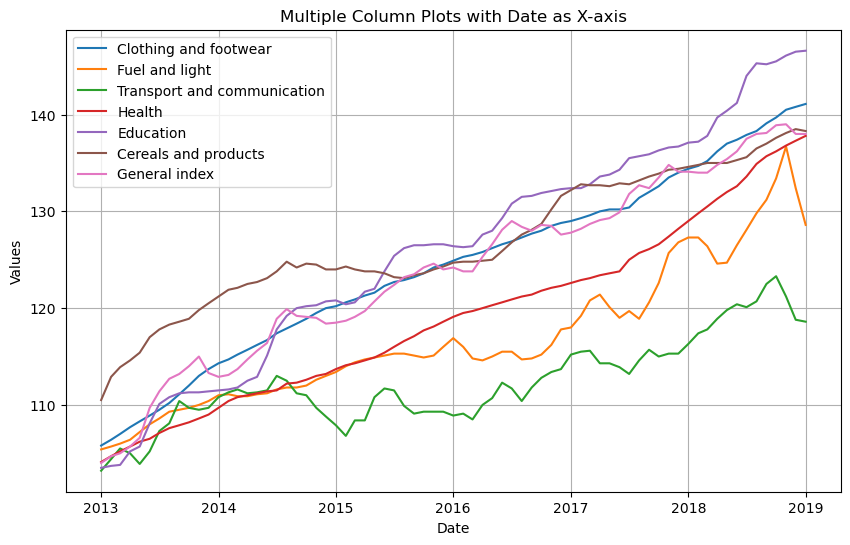

In [10]:
# Plot the specified columns
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Clothing and footwear'], label='Clothing and footwear')
plt.plot(df['Date'], df['Fuel and light'], label='Fuel and light')
plt.plot(df['Date'], df['Transport and communication'], label='Transport and communication')
plt.plot(df['Date'], df['Health'], label='Health')
plt.plot(df['Date'], df['Education'], label='Education')
plt.plot(df['Date'], df['Cereals and products'], label='Cereals and products')
plt.plot(df['Date'], df['General index'], label='General index')
# Add grid, legend, and labels
plt.grid()
plt.legend()
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Multiple Column Plots with Date as X-axis')
plt.show()

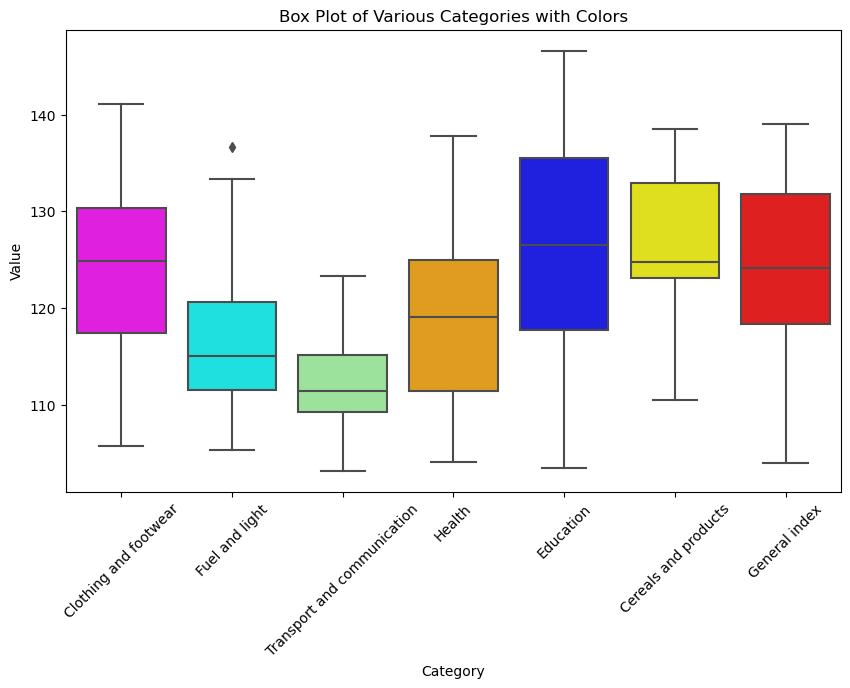

In [11]:
# Melt the DataFrame to long-form or tidy-form
df_melted = df.melt(id_vars='Date', value_vars=['Clothing and footwear', 'Fuel and light', 'Transport and communication', 'Health', 'Education', 'Cereals and products', 'General index'],
                    var_name='Category', value_name='Value')

# Box plot using seaborn with colors
plt.figure(figsize=(10, 6))
sns.boxplot(x='Category', y='Value', data=df_melted, palette=['magenta', 'cyan', 'lightgreen', 'orange', 'blue', 'yellow', 'red'])
plt.title('Box Plot of Various Categories with Colors')
plt.xlabel('Category')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.show()


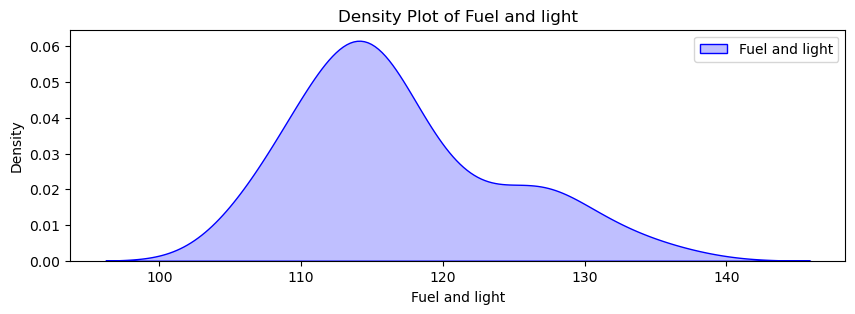

In [12]:
plt.figure(figsize=(10, 3))
sns.kdeplot(df['Fuel and light'], shade=True, color='blue', label='Fuel and light')
plt.title('Density Plot of Fuel and light')
plt.xlabel('Fuel and light')
plt.ylabel('Density')
plt.legend()
plt.show()

### Renaming the columns for Nixtla

We shall be working with the Fuel and Light price index.

In [13]:
new_df = df[['Date', 'Fuel and light']].copy()

# Rename 'Date' column to 'ds' and set unique_id as 1
new_df.rename(columns={'Date': 'ds', 'Fuel and light': 'y'}, inplace=True)
new_df['unique_id'] = 1

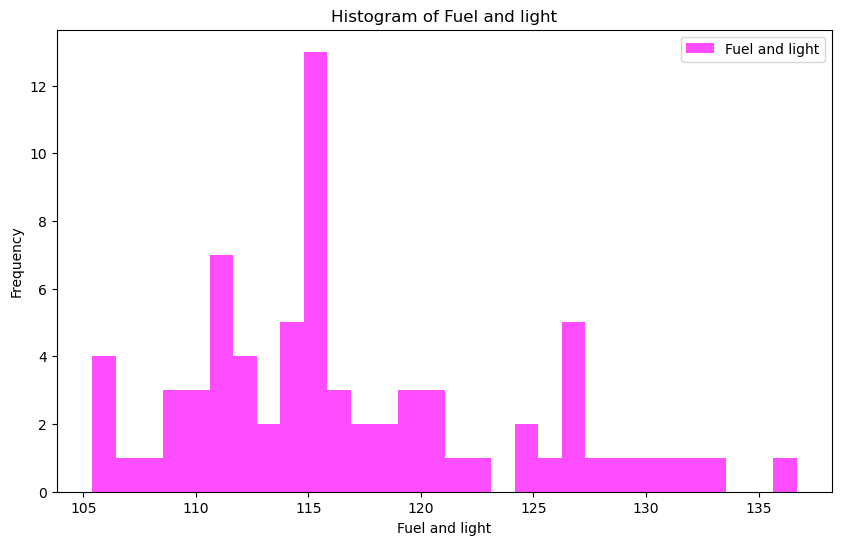

In [14]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(new_df['y'], bins=30,color ='magenta',alpha=0.7, label='Fuel and light')

plt.title('Histogram of Fuel and light')
plt.xlabel('Fuel and light')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [15]:
new_df.head()

ds      y  unique_id
0 2013-01-01  105.4          1
1 2013-02-01  105.7          1
2 2013-03-01  106.0          1
3 2013-04-01  106.4          1
4 2013-05-01  107.2          1

In [16]:
print(new_df.dtypes)

ds           datetime64[ns]
y                   float64
unique_id             int64
dtype: object


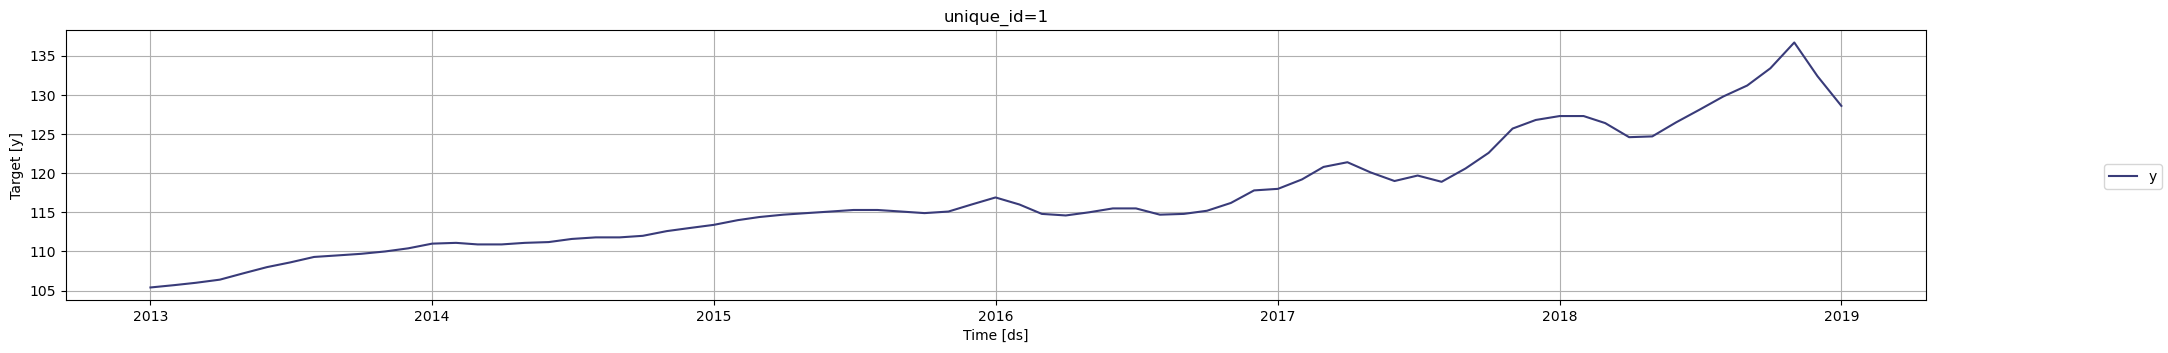

In [17]:
#Plotting the data
StatsForecast.plot(new_df)

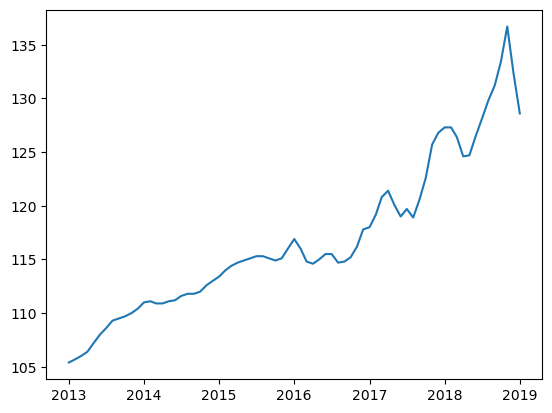

In [18]:
plt.plot(new_df[["ds","y"]].set_index("ds"))

## Time series Decomposition

### Additive Model: using Seasonal Decompose

In [19]:
# Set 'ds' as the index
new_df.set_index('ds', inplace=True)

# Perform seasonal decomposition
result_add = seasonal_decompose(new_df['y'], model='additive',extrapolate_trend="freq")

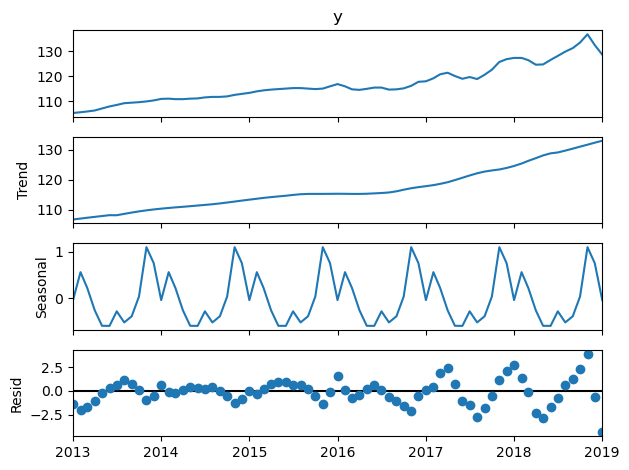

In [20]:
# Plot the decomposition
result_add.plot()
plt.show()

In [21]:
#Trend
result_add.trend

ds
2013-01-01    106.857066
2013-02-01    107.140691
2013-03-01    107.424315
2013-04-01    107.707940
2013-05-01    107.991565
                 ...    
2018-09-01    130.360038
2018-10-01    131.016856
2018-11-01    131.673674
2018-12-01    132.330492
2019-01-01    132.987311
Name: trend, Length: 73, dtype: float64

In [22]:
#Seasonal index (repeats each year)
result_add.seasonal

ds
2013-01-01   -0.039225
2013-02-01    0.559837
2013-03-01    0.219511
2013-04-01   -0.259705
2013-05-01   -0.590309
                ...   
2018-09-01   -0.385749
2018-10-01    0.036726
2018-11-01    1.096006
2018-12-01    0.753203
2019-01-01   -0.039225
Name: seasonal, Length: 73, dtype: float64

In [23]:
result_add.resid

ds
2013-01-01   -1.417841
2013-02-01   -2.000527
2013-03-01   -1.643826
2013-04-01   -1.048235
2013-05-01   -0.201256
                ...   
2018-09-01    1.225711
2018-10-01    2.346418
2018-11-01    3.930320
2018-12-01   -0.683696
2019-01-01   -4.348086
Name: resid, Length: 73, dtype: float64

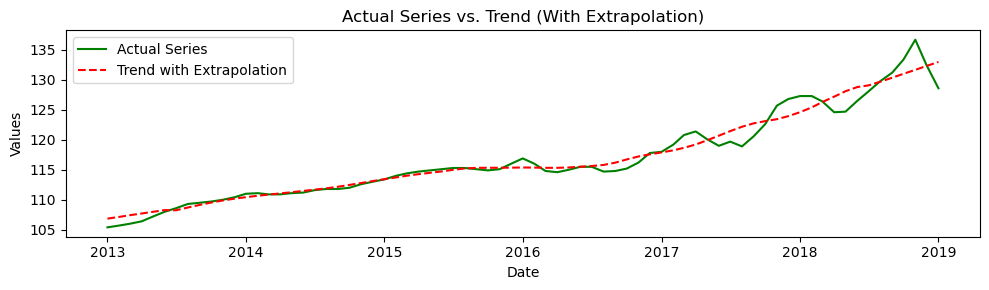

In [24]:
# Plot the actual series vs. trend component
fig, ax = plt.subplots(figsize=(10, 3))

# Plot actual series
ax.plot(new_df.index, new_df['y'], label='Actual Series', color='green')

# Plot trend component
ax.plot(result_add.trend.index, result_add.trend, label='Trend with Extrapolation', color='red',linestyle='--')

ax.set_title('Actual Series vs. Trend (With Extrapolation)')
ax.set_ylabel('Values')
ax.legend(loc='upper left')

plt.xlabel('Date')
plt.tight_layout()
plt.show()

### Multiplicative Model: using Seasonal Decompose

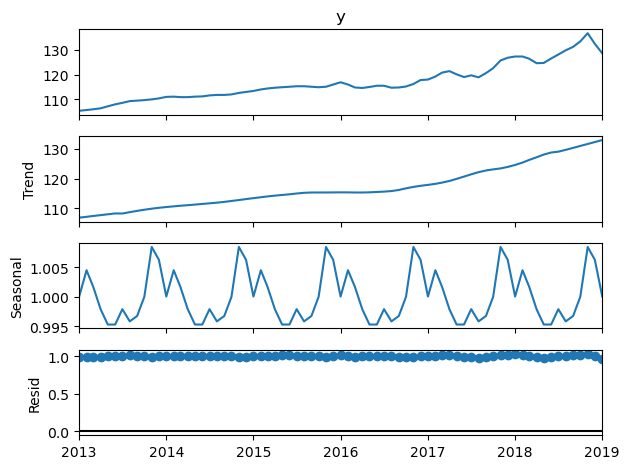

In [25]:
result_mult = seasonal_decompose(new_df['y'], model = "multiplicative", extrapolate_trend="freq")
result_mult.plot()
plt.show()

In [26]:
#Trend
result_mult.trend

ds
2013-01-01    106.857066
2013-02-01    107.140691
2013-03-01    107.424315
2013-04-01    107.707940
2013-05-01    107.991565
                 ...    
2018-09-01    130.360038
2018-10-01    131.016856
2018-11-01    131.673674
2018-12-01    132.330492
2019-01-01    132.987311
Name: trend, Length: 73, dtype: float64

In [27]:
#Seasonal index (repeats each year)
result_mult.seasonal

ds
2013-01-01    1.000048
2013-02-01    1.004509
2013-03-01    1.001695
2013-04-01    0.997888
2013-05-01    0.995308
                ...   
2018-09-01    0.996760
2018-10-01    1.000006
2018-11-01    1.008452
2018-12-01    1.006273
2019-01-01    1.000048
Name: seasonal, Length: 73, dtype: float64

In [28]:
#Residuals
result_mult.resid

ds
2013-01-01    0.986317
2013-02-01    0.982125
2013-03-01    0.985072
2013-04-01    0.989947
2013-05-01    0.997350
                ...   
2018-09-01    1.009715
2018-10-01    1.018183
2018-11-01    1.029472
2018-12-01    0.994288
2019-01-01    0.966963
Name: resid, Length: 73, dtype: float64

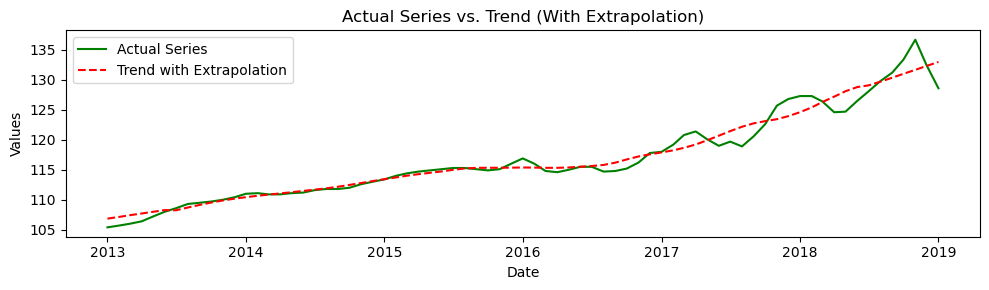

In [29]:
# Plot the actual series vs. trend component
fig, ax = plt.subplots(figsize=(10, 3))

# Plot actual series
ax.plot(new_df.index, new_df['y'], label='Actual Series', color='green')

# Plot trend component
ax.plot(result_mult.trend.index, result_mult.trend, label='Trend with Extrapolation', color='red',linestyle='--')

ax.set_title('Actual Series vs. Trend (With Extrapolation)')
ax.set_ylabel('Values')
ax.legend(loc='upper left')

plt.xlabel('Date')
plt.tight_layout()
plt.show()

## Forecasting

In [30]:
# Split into train and test sets (80:20 ratio)
train_size = int(len(new_df) * 0.8)
train_df = new_df.iloc[:train_size]
test_df = new_df.iloc[train_size:]

In [31]:
#Printing the shape of data
print(train_df.shape, test_df.shape)

(58, 2) (15, 2)


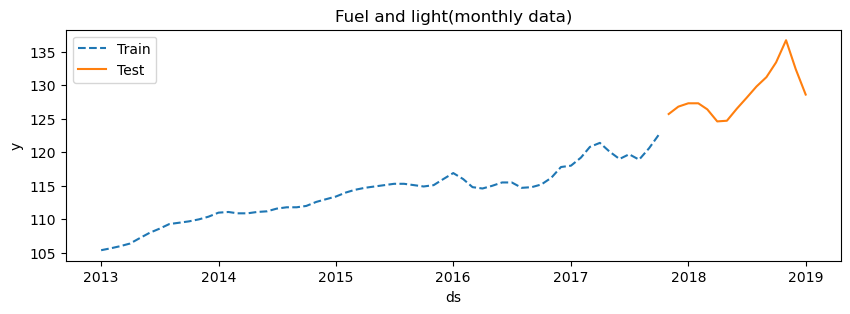

In [32]:
#Plot training and testing data using Seaborn
plt.figure(figsize=(10,3))
sns.lineplot(data=train_df,x="ds", y="y", label="Train", linestyle="--")
sns.lineplot(data=test_df, x="ds", y="y", label="Test")
plt.title("Fuel and light(monthly data)");
plt.show()

In [33]:
#Forecast horizon = number of months that we want to forecast into the future
horizon = len(test_df)

In [34]:
test_df.head()

y  unique_id
ds                          
2017-11-01  125.7          1
2017-12-01  126.8          1
2018-01-01  127.3          1
2018-02-01  127.3          1
2018-03-01  126.4          1

In [35]:
horizon

15

In [36]:
#Initializing empty models list that we'll add models to
models = []

### Simple Models

#### Average

In [37]:
# Average model
models.append(HistoricAverage(alias="Average"))

#### Naive

In [38]:
#Naive model
models.append(Naive(alias="Naive"))

#### Seasonal Naive

In [39]:
#Seasonal Naive model
models.append(SeasonalNaive(season_length=12, alias="Seasonal Naive"))

#### Drift

In [40]:
#Drift model
models.append(RandomWalkWithDrift(alias="Drift"))

In [41]:
#Printing list of all models added so far
models

[Average, Naive, Seasonal Naive, Drift]

In [42]:
# Prepare the DataFrame for StatsForecast
new_df_reset = train_df.reset_index()

In [43]:
# Initialize StatsForecast with new_df_reset
sf = StatsForecast(df=new_df_reset, models=models, freq='M', n_jobs=-1)

In [44]:
#Fit the model
sf.fit()

StatsForecast(models=[Average,Naive,Seasonal Naive,Drift])

In [45]:
#See fitted values from the models
result_avg = sf.fitted_[0,0].model_
result_naive = sf.fitted_[0,1].model_
result_snaive = sf.fitted_[0,2].model_
result_drift = sf.fitted_[0,3].model_

In [46]:
#Extract only fitted values from the models into a dataframe
fitted_df = pd.DataFrame()

fitted_df["fitted_avg"] = result_avg.get("fitted")
fitted_df["fitted_naive"] = result_naive.get("fitted")
fitted_df["fitted_drift"] = result_drift.get("fitted")
fitted_df["fitted_snaive"] = result_snaive.get("fitted")


#Also have the timestamp
fitted_df["ds"] = train_df.index

In [47]:
fitted_df.tail(13)

fitted_avg  fitted_naive  fitted_drift  fitted_snaive         ds
45  113.805176    114.800003    115.101753     114.900002 2016-10-01
46  113.805176    115.199997    115.501755     115.099998 2016-11-01
47  113.805176    116.199997    116.501755     116.000000 2016-12-01
48  113.805176    117.800003    118.101753     116.900002 2017-01-01
49  113.805176    118.000000    118.301758     116.000000 2017-02-01
50  113.805176    119.199997    119.501755     114.800003 2017-03-01
51  113.805176    120.800003    121.101753     114.599998 2017-04-01
52  113.805176    121.400002    121.701752     115.000000 2017-05-01
53  113.805176    120.099998    120.401756     115.500000 2017-06-01
54  113.805176    119.000000    119.301758     115.500000 2017-07-01
55  113.805176    119.699997    120.001755     114.699997 2017-08-01
56  113.805176    118.900002    119.201752     114.800003 2017-09-01
57  113.805176    120.599998    120.901756     115.199997 2017-10-01

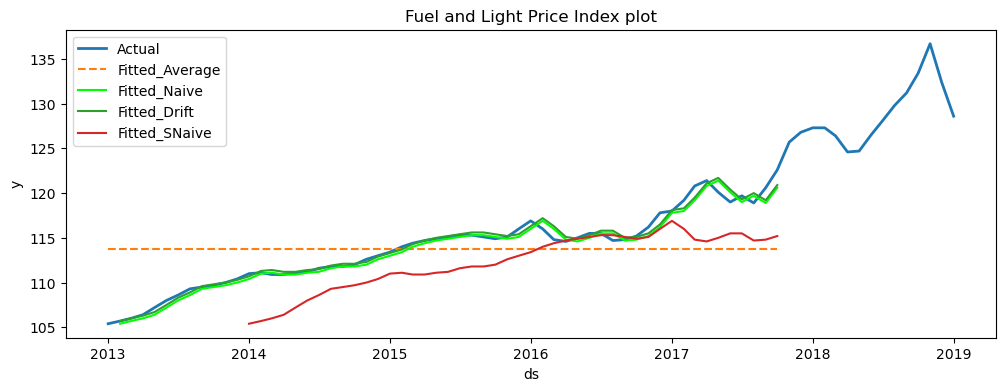

In [48]:
#Plot the actuals vs. fitted values for all Models 
plt.figure(figsize=(12,4))

#Actual data
sns.lineplot(data=new_df, x="ds", y="y", label="Actual", linewidth=2)

#Average model fitted values
sns.lineplot(data=fitted_df,x="ds", y="fitted_avg", label="Fitted_Average", linestyle="--", )

#Naive model fitted values
sns.lineplot(data=fitted_df, x="ds", y="fitted_naive", label="Fitted_Naive", color="lime")

#Drift model fitted values
sns.lineplot(data=fitted_df, x="ds", y="fitted_drift", label="Fitted_Drift")

#Seasonal Naive model fitted values
sns.lineplot(data=fitted_df, x="ds", y="fitted_snaive", label="Fitted_SNaive")

#Add title and show
plt.title("Fuel and Light Price Index plot");
plt.show()

## Forecast using the Simple models

In [49]:
#Forecast
Y_hat = sf.forecast(h=horizon, fitted=True)
Y_hat.head()

ds     Average       Naive  Seasonal Naive       Drift
unique_id                                                               
1         2017-10-31  113.805176  122.599998      116.199997  122.901756
1         2017-11-30  113.805176  122.599998      117.800003  123.203506
1         2017-12-31  113.805176  122.599998      118.000000  123.505264
1         2018-01-31  113.805176  122.599998      119.199997  123.807014
1         2018-02-28  113.805176  122.599998      120.800003  124.108772

In [50]:
#See the fitted values for the entire dataset
values=sf.forecast_fitted_values()
values.head()

ds           y     Average       Naive  Seasonal Naive  \
unique_id                                                                  
1         2013-01-01  105.400002  113.805176         NaN             NaN   
1         2013-02-01  105.699997  113.805176  105.400002             NaN   
1         2013-03-01  106.000000  113.805176  105.699997             NaN   
1         2013-04-01  106.400002  113.805176  106.000000             NaN   
1         2013-05-01  107.199997  113.805176  106.400002             NaN   

                Drift  
unique_id              
1                 NaN  
1          105.701752  
1          106.001755  
1          106.301758  
1          106.701752

In [51]:
Y_hat=Y_hat.reset_index()
Y_hat.head()

unique_id         ds     Average       Naive  Seasonal Naive       Drift
0          1 2017-10-31  113.805176  122.599998      116.199997  122.901756
1          1 2017-11-30  113.805176  122.599998      117.800003  123.203506
2          1 2017-12-31  113.805176  122.599998      118.000000  123.505264
3          1 2018-01-31  113.805176  122.599998      119.199997  123.807014
4          1 2018-02-28  113.805176  122.599998      120.800003  124.108772

In [52]:
new_df.head()

y  unique_id
ds                          
2013-01-01  105.4          1
2013-02-01  105.7          1
2013-03-01  106.0          1
2013-04-01  106.4          1
2013-05-01  107.2          1

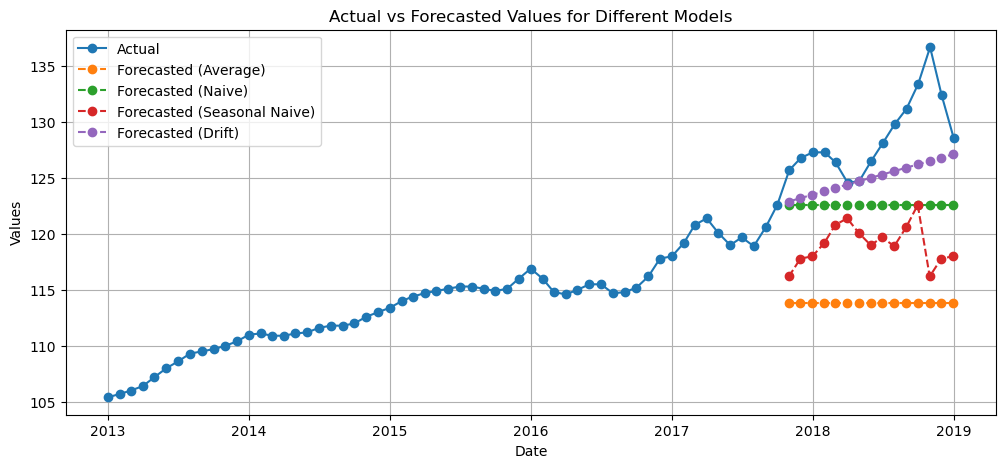

In [53]:
plt.figure(figsize=(12, 5))
plt.plot(new_df.index, new_df['y'], label='Actual', marker='o')

plt.plot(Y_hat['ds'], Y_hat['Average'], label='Forecasted (Average)', linestyle='--', marker='o')
plt.plot(Y_hat['ds'], Y_hat['Naive'], label='Forecasted (Naive)', linestyle='--', marker='o')
plt.plot(Y_hat['ds'], Y_hat['Seasonal Naive'], label='Forecasted (Seasonal Naive)', linestyle='--', marker='o')
plt.plot(Y_hat['ds'], Y_hat['Drift'], label='Forecasted (Drift)', linestyle='--', marker='o')

plt.title('Actual vs Forecasted Values for Different Models')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

In [54]:
# Calculate metrics for each model
metrics = []

for model in ['Average', 'Naive', 'Seasonal Naive', 'Drift']:
    y_true = new_df['y']
    y_pred = Y_hat[model]

In [55]:
test_df.head()

y  unique_id
ds                          
2017-11-01  125.7          1
2017-12-01  126.8          1
2018-01-01  127.3          1
2018-02-01  127.3          1
2018-03-01  126.4          1

In [56]:
Y_hat['Actuals']= test_df['y'].values

In [57]:
Y_hat.head()

unique_id         ds     Average       Naive  Seasonal Naive       Drift  \
0          1 2017-10-31  113.805176  122.599998      116.199997  122.901756   
1          1 2017-11-30  113.805176  122.599998      117.800003  123.203506   
2          1 2017-12-31  113.805176  122.599998      118.000000  123.505264   
3          1 2018-01-31  113.805176  122.599998      119.199997  123.807014   
4          1 2018-02-28  113.805176  122.599998      120.800003  124.108772   

   Actuals  
0    125.7  
1    126.8  
2    127.3  
3    127.3  
4    126.4

### Evaluation Metrics

In [58]:
# Extract actual values
actual_ts = Y_hat['Actuals']

# List of model names (change this based on your actual model names)
model_names = ['Average', 'Naive', 'Seasonal Naive', 'Drift']

# Initialize error DataFrame
error_df = pd.DataFrame(columns=model_names, index=["MAE", "MAPE", "MSE"])

# Calculate and store errors for each model
for model in model_names:
    # Calculate MAE
    model_mae = mean_absolute_error(actual_ts, Y_hat[model])
    
    # Calculate MAPE
    model_mape = np.mean(np.abs((actual_ts - Y_hat[model]) / actual_ts)) * 100
    
    # Calculate MSE
    model_mse = mean_squared_error(actual_ts, Y_hat[model])
    
    # Store errors in error_df
    error_df.loc['MAE', model] = np.round(model_mae, 2)
    error_df.loc['MAPE', model] = np.round(model_mape, 2)
    error_df.loc['MSE', model] = np.round(model_mse, 2)

# Print error DataFrame
print("Error Metrics:")
error_df

Error Metrics:


Average  Naive Seasonal Naive  Drift
MAE    14.83   6.03           9.55   3.62
MAPE   11.47   4.63           7.36   2.77
MSE   231.01  47.54          107.1  19.76

## AutoARIMA with Nixtla Multivariate Forecasting

In [59]:
df.head()

Sector  Cereals and products  Meat and fish    Egg  Milk and products  \
0  Urban                 110.5          109.1  113.0              103.6   
1  Urban                 112.9          112.9  116.9              104.0   
2  Urban                 113.9          111.4  113.2              104.3   
3  Urban                 114.6          113.4  106.0              104.7   
4  Urban                 115.4          114.2  102.7              105.5   

   Oils and fats  Fruits  Vegetables  Pulses and products  \
0          103.4   102.3       102.9                105.8   
1          103.5   103.1       104.9                104.1   
2          102.7   104.9       103.8                103.5   
3          102.1   109.5       109.7                104.6   
4          101.5   110.6       123.7                105.2   

   Sugar and Confectionery  ...  Household goods and services  Health  \
0                    105.1  ...                         104.8   104.1   
1                    103.8  ...                         105.2   104.7   
2                    102.6  ...                         105.7   105.2   
3                    102.0  ...                         106.5   105.7   
4                    101.9  ...                         107.1   106.2   

   Transport and communication  Recreation and amusement  Education  \
0                        103.2                     102.9      103.5   
1                        104.4                     103.3      103.7   
2                        105.5                     103.5      103.8   
3                        105.0                     104.0      105.2   
4                        103.9                     104.6      105.7   

   Personal care and effects  Miscellaneous  General index  YearMonth  \
0                      104.3          103.7          104.0    2013-01   
1                      104.3          104.3          104.7    2013-02   
2                      104.2          104.9          105.0    2013-03   
3                      103.2          105.1          105.7    2013-04   
4                      102.6          104.9          106.6    2013-05   

        Date  
0 2013-01-01  
1 2013-02-01  
2 2013-03-01  
3 2013-04-01  
4 2013-05-01  

[5 rows x 30 columns]

In [60]:
df.rename(columns={'Date': 'ds'}, inplace=True)
df['unique_id'] = 1

In [61]:
df.head()

Sector  Cereals and products  Meat and fish    Egg  Milk and products  \
0  Urban                 110.5          109.1  113.0              103.6   
1  Urban                 112.9          112.9  116.9              104.0   
2  Urban                 113.9          111.4  113.2              104.3   
3  Urban                 114.6          113.4  106.0              104.7   
4  Urban                 115.4          114.2  102.7              105.5   

   Oils and fats  Fruits  Vegetables  Pulses and products  \
0          103.4   102.3       102.9                105.8   
1          103.5   103.1       104.9                104.1   
2          102.7   104.9       103.8                103.5   
3          102.1   109.5       109.7                104.6   
4          101.5   110.6       123.7                105.2   

   Sugar and Confectionery  ...  Health  Transport and communication  \
0                    105.1  ...   104.1                        103.2   
1                    103.8  ...   104.7                        104.4   
2                    102.6  ...   105.2                        105.5   
3                    102.0  ...   105.7                        105.0   
4                    101.9  ...   106.2                        103.9   

   Recreation and amusement  Education  Personal care and effects  \
0                     102.9      103.5                      104.3   
1                     103.3      103.7                      104.3   
2                     103.5      103.8                      104.2   
3                     104.0      105.2                      103.2   
4                     104.6      105.7                      102.6   

   Miscellaneous  General index  YearMonth         ds  unique_id  
0          103.7          104.0    2013-01 2013-01-01          1  
1          104.3          104.7    2013-02 2013-02-01          1  
2          104.9          105.0    2013-03 2013-03-01          1  
3          105.1          105.7    2013-04 2013-04-01          1  
4          104.9          106.6    2013-05 2013-05-01          1  

[5 rows x 31 columns]

We are predicting the Fuel and Light index on the basis of General index. First we predict the Exogenous Variable that is General index using a baseline model, here we used HoltWinters method. Then on the basis of the predicted values of General Index, we shall predict the Fuel and Light index in the same test time frame.

In [62]:
#Simple data preprocessing for Nixtla
df_nix = df[["Fuel and light", "General index","ds","unique_id"]]
df_nix.columns = ["y","General index","ds","unique_id"]
df_nix.head()

y  General index         ds  unique_id
0  105.4          104.0 2013-01-01          1
1  105.7          104.7 2013-02-01          1
2  106.0          105.0 2013-03-01          1
3  106.4          105.7 2013-04-01          1
4  107.2          106.6 2013-05-01          1

### Train Test Split

In [63]:
train_df1 = df_nix.iloc[:-15]  # Get all rows except the last 15
test_df1 = df_nix.iloc[-15:]   # Get the last 15 rows

In [64]:
sf_2 = StatsForecast(df=train_df1,
                   models=[AutoARIMA(season_length=12)],
                   freq='M',  
                   n_jobs=-1,
                   )

sf_2.fit(train_df1)

StatsForecast(models=[AutoARIMA])

In [65]:
model_params_exog = sf_2.fitted_[0][0].model_

### Residual Analysis

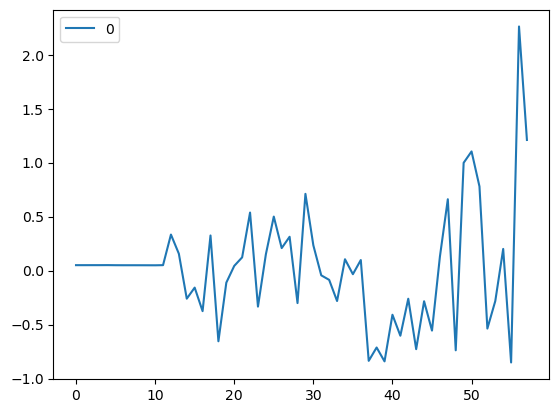

In [66]:
#Residual analysis
residuals = pd.DataFrame(model_params_exog["residuals"])
residuals.plot()
plt.show()

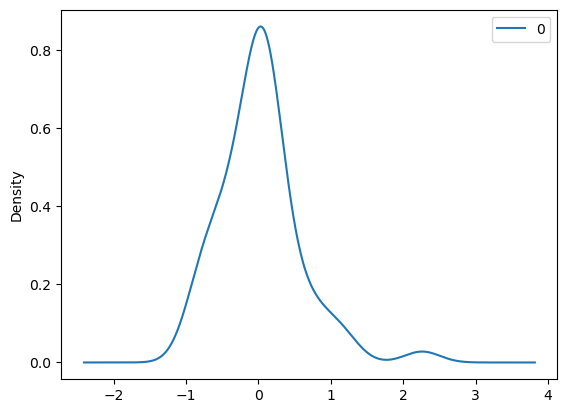

In [67]:
# Density plot of residuals
residuals.plot(kind='kde')
plt.show()

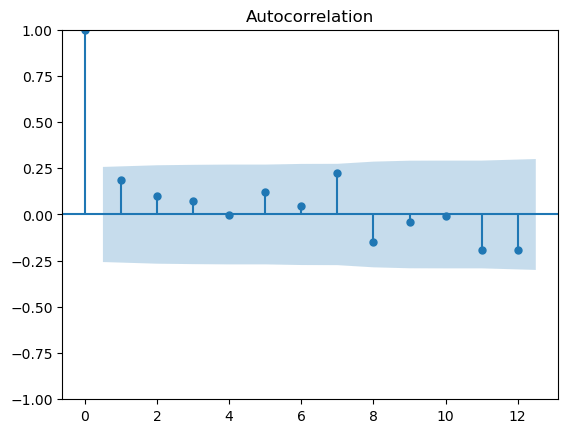

In [68]:
#Plot Autocorrelation of Residuals
plot_acf(residuals, lags=12)
plt.show()

In [69]:
# Summary statistics of residuals
print(residuals.describe())

               0
count  58.000000
mean    0.025941
std     0.553695
min    -0.851453
25%    -0.283619
50%     0.049582
75%     0.189527
max     2.261949


## Forecast Exogenous Variable

In [70]:
df_exog=train_df1[[ "General index","ds","unique_id"]]
df_exog.columns = ["y","ds","unique_id"]

In [71]:
#Get forecast of  exogenous variable for next 15 months using a HoltWinters method
models_3 = [DynamicOptimizedTheta(season_length=12, decomposition_type="additive", alias="Theta")]
sf_exog = StatsForecast(df=df_exog,
                   models=models_3,
                   freq='M', # monthly frequency
                   n_jobs=-1)

In [72]:
df_forecast_EXOG = pd.DataFrame()
df_forecast_EXOG["ds"] = test_df1["ds"]
df_forecast_EXOG["General index"] = sf_exog.forecast(15)["Theta"].values
df_forecast_EXOG["unique_id"] = 1

In [73]:
df_forecast_EXOG.head()

ds  General index  unique_id
58 2017-11-01     133.804321          1
59 2017-12-01     134.116196          1
60 2018-01-01     134.427704          1
61 2018-02-01     134.738708          1
62 2018-03-01     135.049103          1

In [74]:
len(df_forecast_EXOG)

15

In [75]:
#Get forecast
arima_forecast_fuel = sf_2.forecast(h=15, X_df = df_forecast_EXOG)
arima_forecast_fuel.head()

ds   AutoARIMA
unique_id                       
1         2017-10-31  122.381157
1         2017-11-30  122.960281
1         2017-12-31  123.119972
1         2018-01-31  122.627190
1         2018-02-28  121.983261

In [76]:
Y_hat.head()

unique_id         ds     Average       Naive  Seasonal Naive       Drift  \
0          1 2017-10-31  113.805176  122.599998      116.199997  122.901756   
1          1 2017-11-30  113.805176  122.599998      117.800003  123.203506   
2          1 2017-12-31  113.805176  122.599998      118.000000  123.505264   
3          1 2018-01-31  113.805176  122.599998      119.199997  123.807014   
4          1 2018-02-28  113.805176  122.599998      120.800003  124.108772   

   Actuals  
0    125.7  
1    126.8  
2    127.3  
3    127.3  
4    126.4

In [77]:
arima_forecast_fuel.head()

ds   AutoARIMA
unique_id                       
1         2017-10-31  122.381157
1         2017-11-30  122.960281
1         2017-12-31  123.119972
1         2018-01-31  122.627190
1         2018-02-28  121.983261

In [78]:
Y_hat['AutoARIMA'] = arima_forecast_fuel['AutoARIMA'].values

In [79]:
Y_hat.head()

unique_id         ds     Average       Naive  Seasonal Naive       Drift  \
0          1 2017-10-31  113.805176  122.599998      116.199997  122.901756   
1          1 2017-11-30  113.805176  122.599998      117.800003  123.203506   
2          1 2017-12-31  113.805176  122.599998      118.000000  123.505264   
3          1 2018-01-31  113.805176  122.599998      119.199997  123.807014   
4          1 2018-02-28  113.805176  122.599998      120.800003  124.108772   

   Actuals   AutoARIMA  
0    125.7  122.381157  
1    126.8  122.960281  
2    127.3  123.119972  
3    127.3  122.627190  
4    126.4  121.983261

### Moving Average Analysis of the Data:

- Moving average (MA) helps in smoothing out short-term fluctuations and highlighting longer-term trends or cycles in the data.
- By averaging the data points within a specific window, the noise is reduced, making the overall trend more apparent.

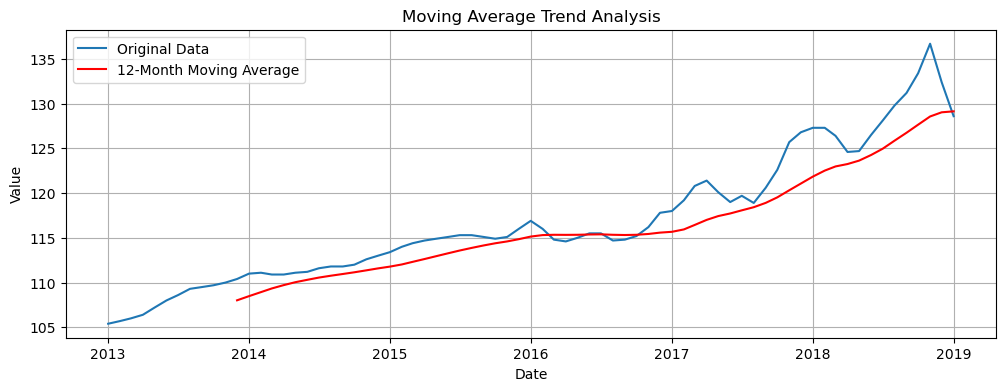

In [80]:
new_df['moving_avg'] = new_df['y'].rolling(window=12).mean()  # 12-month moving average

plt.figure(figsize=(12, 4))
plt.plot(new_df.index, new_df['y'], label='Original Data')
plt.plot(new_df.index, new_df['moving_avg'], label='12-Month Moving Average', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Moving Average Trend Analysis')
plt.legend()
plt.grid(True)
plt.show()

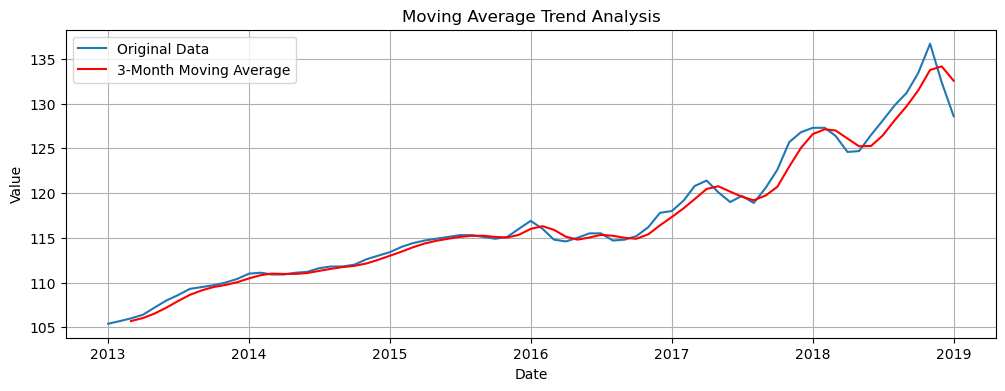

In [81]:
new_df['moving_avg'] = new_df['y'].rolling(window=3).mean()  # 3-month moving average
plt.figure(figsize=(12, 4))
plt.plot(new_df.index, new_df['y'], label='Original Data')
plt.plot(new_df.index, new_df['moving_avg'], label='3-Month Moving Average', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Moving Average Trend Analysis')
plt.legend()
plt.grid(True)
plt.show()

### Forecasting using Prophet

In [82]:
train_df.head()

y  unique_id
ds                          
2013-01-01  105.4          1
2013-02-01  105.7          1
2013-03-01  106.0          1
2013-04-01  106.4          1
2013-05-01  107.2          1

In [83]:
train_df = train_df.reset_index(names=['ds'])
train_df.head()

ds      y  unique_id
0 2013-01-01  105.4          1
1 2013-02-01  105.7          1
2 2013-03-01  106.0          1
3 2013-04-01  106.4          1
4 2013-05-01  107.2          1

In [84]:
len(train_df)

58

In [85]:
train_df.tail()

ds      y  unique_id
53 2017-06-01  119.0          1
54 2017-07-01  119.7          1
55 2017-08-01  118.9          1
56 2017-09-01  120.6          1
57 2017-10-01  122.6          1

In [86]:
test_df.head()

y  unique_id
ds                          
2017-11-01  125.7          1
2017-12-01  126.8          1
2018-01-01  127.3          1
2018-02-01  127.3          1
2018-03-01  126.4          1

In [87]:
test_df = test_df.reset_index(names=['ds'])
test_df.head()

ds      y  unique_id
0 2017-11-01  125.7          1
1 2017-12-01  126.8          1
2 2018-01-01  127.3          1
3 2018-02-01  127.3          1
4 2018-03-01  126.4          1

In [88]:
# Python
m = Prophet()
m.fit(train_df)

22:10:55 - cmdstanpy - INFO - Chain [1] start processing
22:10:55 - cmdstanpy - INFO - Chain [1] done processing


In [89]:
future = m.make_future_dataframe(periods=15,freq='MS')
forecast = m.predict(future)

In [90]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(15)

ds        yhat  yhat_lower  yhat_upper
58 2017-11-01  122.142573  121.438053  122.848994
59 2017-12-01  123.214862  122.455965  123.945832
60 2018-01-01  123.937561  123.144963  124.642844
61 2018-02-01  124.390768  123.600783  125.137086
62 2018-03-01  124.696911  123.837189  125.540541
63 2018-04-01  125.070690  124.220713  125.917098
64 2018-05-01  125.244467  124.302910  126.229055
65 2018-06-01  125.416897  124.327125  126.418404
66 2018-07-01  125.893181  124.620744  127.024619
67 2018-08-01  126.006280  124.616474  127.321391
68 2018-09-01  126.508880  124.807651  127.880244
69 2018-10-01  127.113150  125.351739  128.646974
70 2018-11-01  127.652926  125.595126  129.337706
71 2018-12-01  128.676428  126.464287  130.428983
72 2019-01-01  129.647522  127.287154  131.748314

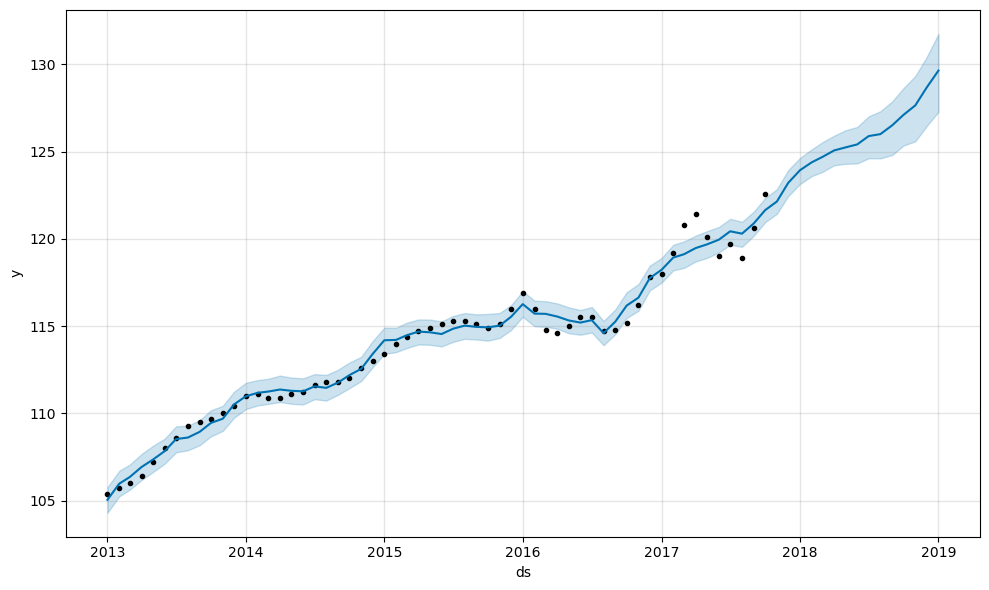

In [91]:
fig1=m.plot(forecast)

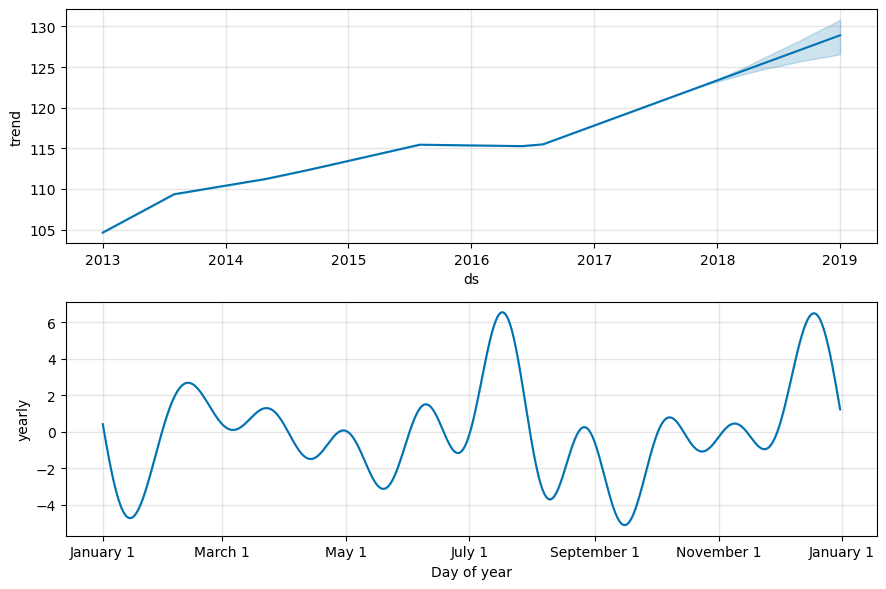

In [92]:
# Plot the trend components
fig2=m.plot_components(forecast)

In [93]:
pred=forecast.iloc[-15:]
pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

ds        yhat  yhat_lower  yhat_upper
58 2017-11-01  122.142573  121.438053  122.848994
59 2017-12-01  123.214862  122.455965  123.945832
60 2018-01-01  123.937561  123.144963  124.642844
61 2018-02-01  124.390768  123.600783  125.137086
62 2018-03-01  124.696911  123.837189  125.540541
63 2018-04-01  125.070690  124.220713  125.917098
64 2018-05-01  125.244467  124.302910  126.229055
65 2018-06-01  125.416897  124.327125  126.418404
66 2018-07-01  125.893181  124.620744  127.024619
67 2018-08-01  126.006280  124.616474  127.321391
68 2018-09-01  126.508880  124.807651  127.880244
69 2018-10-01  127.113150  125.351739  128.646974
70 2018-11-01  127.652926  125.595126  129.337706
71 2018-12-01  128.676428  126.464287  130.428983
72 2019-01-01  129.647522  127.287154  131.748314

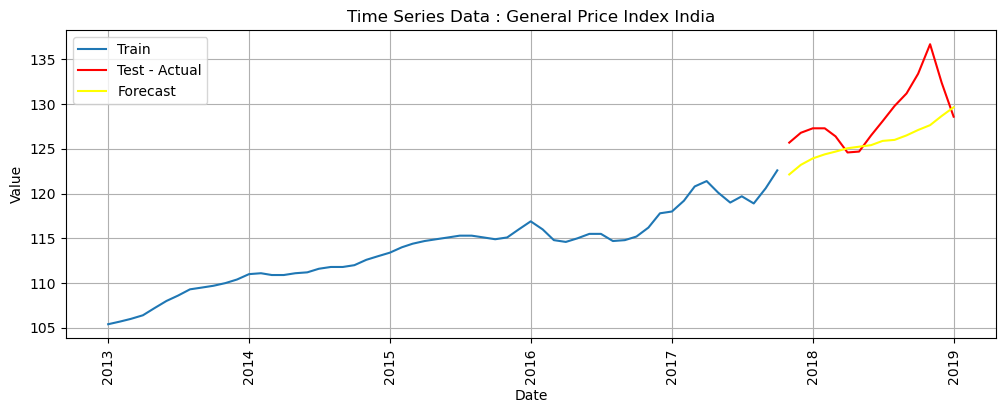

In [94]:
plt.figure(figsize=(12,4))
plt.plot(train_df['ds'], train_df['y'], label='Train')
plt.plot(test_df['ds'], test_df['y'], label='Test - Actual', color='red')
plt.plot(pred['ds'], pred['yhat'], label='Forecast', color='yellow')


plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Data : General Price Index India')
plt.legend()
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

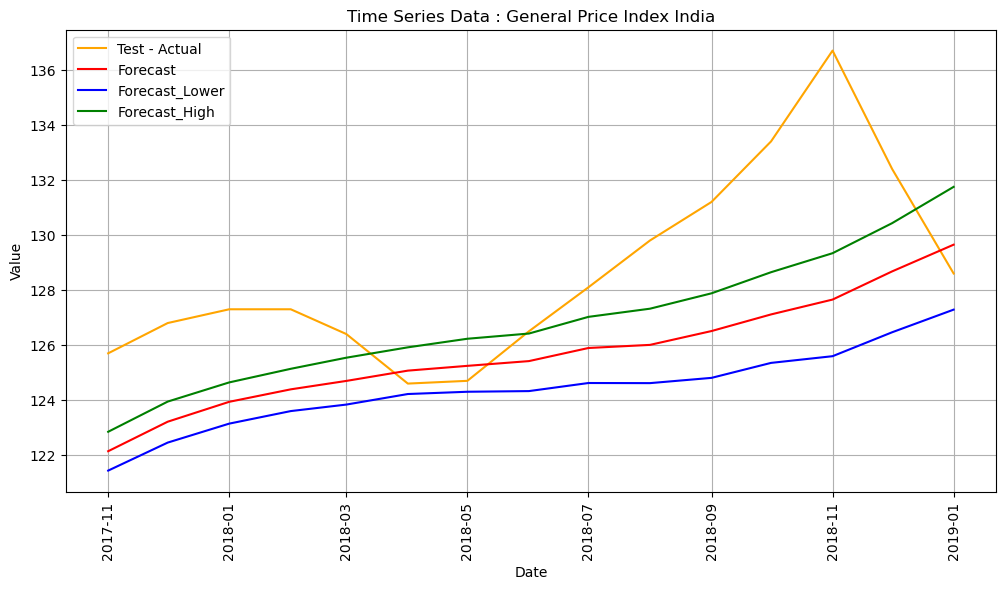

In [95]:
plt.figure(figsize=(12, 6))

plt.plot(test_df['ds'], test_df['y'], label='Test - Actual', color='orange')
plt.plot(pred['ds'], pred['yhat'], label='Forecast', color='red')
plt.plot(pred['ds'], pred['yhat_lower'], label='Forecast_Lower', color='blue')
plt.plot(pred['ds'], pred['yhat_upper'], label='Forecast_High', color='green')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Data : General Price Index India')
plt.legend()
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [96]:
# Calculate MAE and MAPE
mae = mean_absolute_error(test_df['y'], pred['yhat'])
print(f"MAE: {mae}")

MAE: 3.200817402771162


In [97]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(test_df['y'], pred['yhat'])
print(f"MAPE: {mape}%")

MAPE: 2.452071249272474%


### Plotly Plots

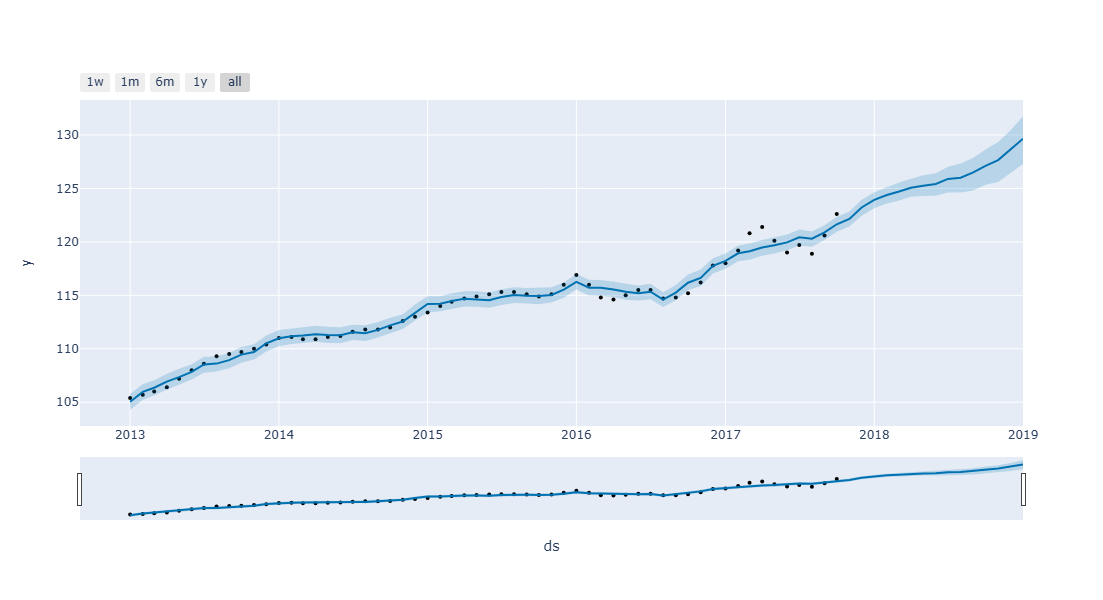

In [98]:
plot_plotly(m, forecast)

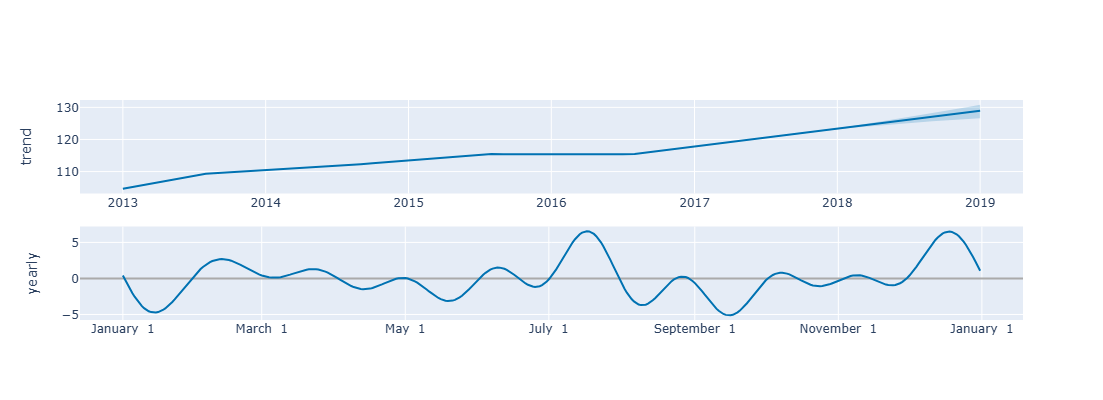

In [99]:
plot_components_plotly(m, forecast)

In [100]:
Y_hat['Prophet'] = pred['yhat'].values

In [101]:
Y_hat.head()

unique_id         ds     Average       Naive  Seasonal Naive       Drift  \
0          1 2017-10-31  113.805176  122.599998      116.199997  122.901756   
1          1 2017-11-30  113.805176  122.599998      117.800003  123.203506   
2          1 2017-12-31  113.805176  122.599998      118.000000  123.505264   
3          1 2018-01-31  113.805176  122.599998      119.199997  123.807014   
4          1 2018-02-28  113.805176  122.599998      120.800003  124.108772   

   Actuals   AutoARIMA     Prophet  
0    125.7  122.381157  122.142573  
1    126.8  122.960281  123.214862  
2    127.3  123.119972  123.937561  
3    127.3  122.627190  124.390768  
4    126.4  121.983261  124.696911

In [102]:
# Extract actual values
actual_ts = Y_hat['Actuals']

# List of model names (change this based on your actual model names)
model_names = ['Average', 'Naive', 'Seasonal Naive', 'Drift', 'AutoARIMA', 'Prophet',]

# Initialize error DataFrame
error_df = pd.DataFrame(columns=model_names, index=["MAE", "MAPE", "MSE"])

# Calculate and store errors for each model
for model in model_names:
    # Calculate MAE
    model_mae = mean_absolute_error(actual_ts, Y_hat[model])
    
    # Calculate MAPE
    model_mape = np.mean(np.abs((actual_ts - Y_hat[model]) / actual_ts)) * 100
    
    # Calculate MSE
    model_mse = mean_squared_error(actual_ts, Y_hat[model])
    
    # Store errors in error_df
    error_df.loc['MAE', model] = np.round(model_mae, 2)
    error_df.loc['MAPE', model] = np.round(model_mape, 2)
    error_df.loc['MSE', model] = np.round(model_mse, 2)

# Print error DataFrame
print("Error Metrics:")
error_df

Error Metrics:


Average  Naive Seasonal Naive  Drift AutoARIMA Prophet
MAE    14.83   6.03           9.55   3.62       6.9     3.2
MAPE   11.47   4.63           7.36   2.77       5.3    2.45
MSE   231.01  47.54          107.1  19.76     60.59   15.17

#### Based on the error metrics provided for different forecasting models, the Prophet model demonstrates the best performance across all error metrics.

- MAE (Mean Absolute Error): Prophet has the lowest MAE at 3.2, indicating it has the smallest average absolute errors among the models.
- MAPE (Mean Absolute Percentage Error): Prophet also has the lowest MAPE at 2.45%, showing its superior accuracy in terms of percentage errors.
- MSE (Mean Squared Error): With the lowest MSE of 15.17, Prophet indicates that it has the smallest squared errors, making it the most precise model.
- In comparison to other models, Prophet consistently outperforms, making it the most reliable choice for forecasting in this context.

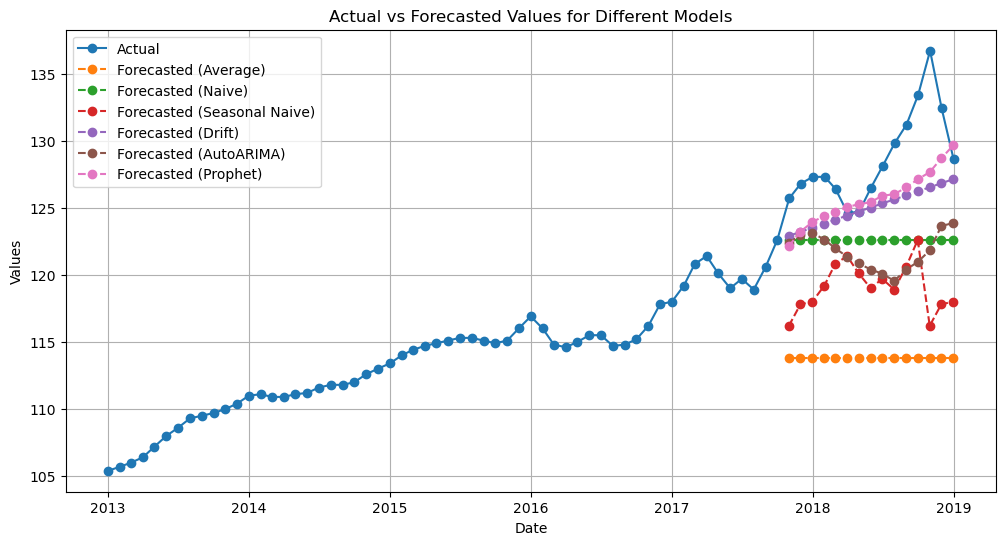

In [103]:
plt.figure(figsize=(12, 6))
plt.plot(new_df.index, new_df['y'], label='Actual', marker='o')

plt.plot(Y_hat['ds'], Y_hat['Average'], label='Forecasted (Average)', linestyle='--', marker='o')
plt.plot(Y_hat['ds'], Y_hat['Naive'], label='Forecasted (Naive)', linestyle='--', marker='o')
plt.plot(Y_hat['ds'], Y_hat['Seasonal Naive'], label='Forecasted (Seasonal Naive)', linestyle='--', marker='o')
plt.plot(Y_hat['ds'], Y_hat['Drift'], label='Forecasted (Drift)', linestyle='--', marker='o')
plt.plot(Y_hat['ds'], Y_hat['AutoARIMA'], label='Forecasted (AutoARIMA)', linestyle='--', marker='o')
plt.plot(Y_hat['ds'], Y_hat['Prophet'], label='Forecasted (Prophet)', linestyle='--', marker='o')

plt.title('Actual vs Forecasted Values for Different Models')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

## Analysis

The plot showcases the actual vs. forecasted values for different models over time from 2013 to 2019. Here are the key observations and analysis:

1. **Actual vs. Forecasted Trends**:
    - The blue line represents the actual values, showing a clear upward trend with some fluctuations, especially towards the end of the period.
    - The forecasted values from different models are shown with distinct markers and colors.

2. **Performance of Models**:
    - **Prophet (Pink dashed line)**: The Prophet model closely follows the trend of the actual values. It captures the upward trend and seasonal variations reasonably well, particularly during the later period.
    - **AutoARIMA (Brown dashed line)**: AutoARIMA also shows a good fit, but it tends to lag slightly behind the actual values and exhibits more variance in its predictions.
    - **Drift (Red dashed line)**: The Drift model's forecast shows considerable fluctuations and deviates significantly from the actual trend, especially towards the end.
    - **Naive (Green dashed line)**: The Naive model predicts a constant value over time, which is not suitable for the data with a clear trend.
    - **Seasonal Naive (Red dashed line)**: The Seasonal Naive model shows some seasonal adjustments but still deviates significantly from the actual values.
    - **Average (Orange dashed line)**: The Average model predicts a constant value over time, which fails to capture the trend and seasonality in the data.

3. **Model Comparison**:
    - The Prophet model shows the best fit among all models, closely following the actual values with minimal deviations.
    - AutoARIMA performs well but shows slightly more variance.
    - Drift and Seasonal Naive models fail to capture the overall trend accurately.
    - Naive and Average models are the least effective, providing flat predictions that do not account for the upward trend and seasonal variations.

4. **Seasonality and Trend**:
    - The actual values exhibit both a trend and seasonal patterns, which the Prophet and AutoARIMA models handle better than the simpler models like Naive and Average.

5. **Visual Deviation**:
    - The visual deviation between the actual values and forecasted values of the Prophet model is the smallest, indicating its higher accuracy and reliability for this dataset.

Overall, the plot confirms that the Prophet model is the most effective in capturing the underlying trend and seasonality of the data, aligning well with the numerical error metrics provided.
